<img src='./Pokemon.png'>

<h2> Introduction </h2>

<p> There are like a million tutorial on ML, and that's awesome. I like [Aurelien Geron's book best, but the courses Andrew Ng gives are great. So is fast.ai for deep learning. Chris Bishop's book is what you should go for if you're interested in theory. 

Obviously if you would like to actually learn about ML theory, then those resources are the place to go, not to some random student's code. This is just a very simple taster problem that introduces some key concepts. 
    
Also, when actually doing a new ML project, most coding will concern dataset building. That includes web scraping and data sanitization. It turns out most of the code for this is super ugly, and tends to be hidden away. But since it's hidden away, it's not obvious that you can actually acquire new datasets, sanitize them, then throw ML at the problem you care about to get insights.
    
(Also everyone uses the same dataset -- MNIST, CFAR, etc, so it gets boring fast).

I chose a dataset of Pokemon pixel art for several reasons:

1. It's fun
1. There aren't many pokemon (like 700 or so). Since the dataset is small and varied, simple classical ML models with feature engineering often perform better than systems which use more complicated models. We are scientists with a finite amount of microscopy / AFM / SAXS data, even if we datamine the literature. So having 700 varied samples is representative. We'll also have to introduce ideas like regularization to avoid overfitting.
1. The distribution of Pokemon types is highly unbalanced. There aren't many ghost types, and there are loads of normal types. This means that we have to introduce ideas like stratified test-train split etc. to handle the unbalanced data. It also means that evaluation of loss is a bit subtle.
</p>

<h2> The toy problem </h2>

Pokemon is a fictional TV / movie / game / merchandise francise. Maybe you've heard of it. Within the universe, sentient magical creatures are enslaved and take part in an unregulared version of the UFC. Also the slave owners are like 10 years old or something. 

Each Pokemon is has an attribute, called "type", which is a categorical variable, being one of the set set(['water','fire','normal','grass','bug',...]). Some Pokemon also have hybrid types, but I'm going to just ignore those. Each Pokemon also has a visual depiction, consisting of a bitmap (i.e. a 40x40x3 array of ints).

My challenge is: <b> Teach a machine to predict the Pokemon type from image </b>.

<h2> Concepts this tutorial will cover</h2>

1. The different kinds of ML (or really statistical inference) problem
1. Test train split (how do you know if your classifier is working? what is generalization?)
1. What is a classifier?
1. Loss functions (what is a loss function? Are there reasons not to use naive accuracy?)
1. In sample vs out of sample error
1. Simple feature engineering

<h4> Plotting defaults and imports... </h4>

In [106]:
from matplotlib import rc
import matplotlib

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [107]:
import requests 
import os
from matplotlib import pyplot as plt
import numpy as np
import imageio
import re

<h5> Pokemon class: contains all relevant information: name, element (fire, water etc). Also contains image src, so can do automate downloads etc. </h5>

<h5> The next block creates a custom class for Pokemon. It then downloads some data from the website Bulbapedia, including a list of all Pokemon, and their bitmaps, <a>https://bulbapedia.bulbagarden.net/wiki/Main_Page</a>. </h5>

In [ ]:
class Pokemon():
    '''Contains information on each Pokemon: need name, image src (string), and element to initalize.
    Methods allow loading of image (i.e. downloading), conversion of data to an array, and appropriate masking.'''
    def __init__(self,name,image_src,element):
        self.name = name
        self.image_src = image_src
        self.element = element
    def load_image(self):
        if not os.path.isfile("data/"+self.name+'.png'):
            with open("data/"+self.name+'.png','wb+') as f:
                data = requests.get('http://'+self.image_src).content
                f.write(data)
    def get_array(self):
        full_image = imageio.imread("data/"+self.name+".png",pilmode = "RGBA")
        mask = full_image[:,:,-1] == 255
        for i in range(3):
            full_image[:,:,i] = full_image[:,:,i] * mask
        self.array = full_image[:,:,:3] 

def get_pokemon_list():

    url = "https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_body_style"
    response = requests.get(url)

    with open('notes','w+') as f:
        f.write(response.text)
        
    dat = response.text
    x = re.findall('span class="plainlinks"><a href="/wiki/.*</a>.*\n.*\n.*</a>.*\n.*\n.*\n',dat)
    list_of_pokemon = []

    for i in range(0,len(x)):

        src = re.findall('src=".*.png"',x[i])[0][7:-1]
        name_ = re.findall(r'title=".*mon',x[i])[0][7:-9]
        element = re.findall(r'title=".*type',x[i])[0][7:-6]

        pokemon = Pokemon(name_,src,element)
        list_of_pokemon.append(pokemon)
        
    for item in list_of_pokemon:
        item.load_image()
        print (f"loaded {item.name}")
        item.get_array()
        
    return list_of_pokemon

list_of_pokemon = get_pokemon_list()

loaded Shellder
loaded Cloyster
loaded Gastly
loaded Voltorb
loaded Electrode
loaded Koffing
loaded Ditto
loaded Sunkern
loaded Misdreavus
loaded Unown
loaded Pineco
loaded Forretress
loaded Silcoon
loaded Cascoon
loaded Lunatone
loaded Solrock
loaded Castform
loaded Shuppet
loaded Glalie
loaded Clamperl
loaded Mismagius
loaded Bronzor
loaded Rotom
loaded Whirlipede
loaded Cottonee
loaded Solosis
loaded Duosion
loaded Ferroseed
loaded Cryogonal
loaded Shelmet
loaded Carbink
loaded Klefki
loaded Pumpkaboo
loaded Comfey
loaded Minior
loaded Cosmog
loaded Cosmoem
loaded Meltan
loaded Rolycoly
loaded Sinistea
loaded Polteageist
loaded Milcery
loaded Oddish
loaded Poliwag
loaded Doduo
loaded Dodrio
loaded Exeggutor
loaded Tangela
loaded Porygon
loaded Wooper
loaded Porygon2
loaded Torchic
loaded Seedot
loaded Shroomish
loaded Azurill
loaded Cherrim
loaded Bonsly
loaded Roggenrola
loaded Swirlix
loaded Dewpider
loaded Bounsweet
loaded Carkol
loaded Hatenna
loaded Stonjourner
loaded Dracovish

loaded Dewott
loaded Watchog
loaded Pansage
loaded Simisage
loaded Pansear
loaded Simisear
loaded Panpour
loaded Simipour
loaded Drilbur
loaded Audino
loaded Palpitoad
loaded Krookodile
loaded Scraggy
loaded Scrafty
loaded Carracosta
loaded Zoroark
loaded Elgyem
loaded Axew
loaded Fraxure
loaded Haxorus
loaded Cubchoo
loaded Mienfoo
loaded Mienshao
loaded Druddigon
loaded Heatmor
loaded Hydreigon
loaded Thundurus
loaded Zekrom
loaded Kyurem
loaded Chespin
loaded Quilladin
loaded Chesnaught
loaded Braixen
loaded Delphox
loaded Bunnelby
loaded Diggersby
loaded Pancham
loaded Espurr
loaded Meowstic
loaded Helioptile
loaded Heliolisk
loaded Tyrunt
loaded Tyrantrum
loaded Dedenne
loaded Goodra
loaded Zygarde
loaded Hoopa
loaded Incineroar
loaded Lycanroc
loaded Fomantis
loaded Bewear
loaded Passimian
loaded Turtonator
loaded Togedemaru
loaded Hakamo-o
loaded Kommo-o
loaded Xurkitree
loaded Guzzlord
loaded Poipole
loaded Grookey
loaded Thwackey
loaded Scorbunny
loaded Raboot
loaded Cinderace

<h5> Let's have a look at a random selection of 100 Pokemon to get an idea of what our images are like...</h5>

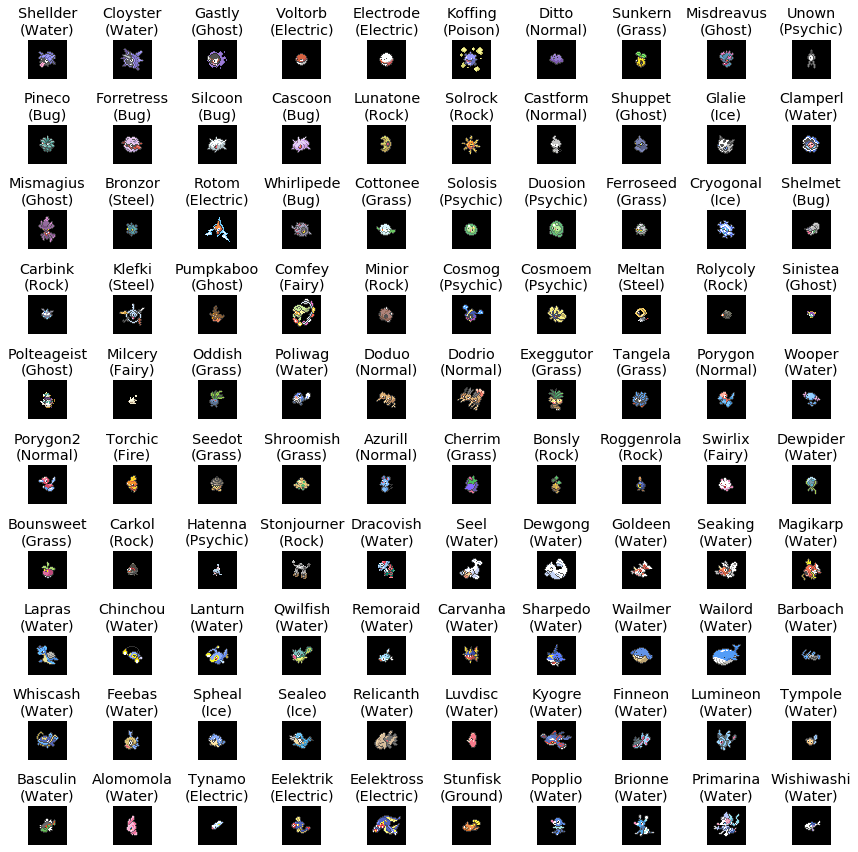

In [105]:
f,ax = plt.subplots(10,10,figsize = (12,12) )

for index,ax_ in enumerate(ax.flatten()):
    ax_.margins(x=0)
    ax_.imshow(list_of_pokemon[index].array)
    ax_.set_title(f"{list_of_pokemon[index].name}\n({list_of_pokemon[index].element})" )
    ax_.axis('off')
    
plt.subplots_adjust(wspace = 0.0)
plt.tight_layout()

<h2> An introduction to the different kinds of ML problem </h2>

<p> Our objective is to predict the type of a Pokemon given its sprite. To start with, we'll focus on just four different types: fire, water, normal, grass.</p>

<h6> What kind of ML problem is this? </h6>

Different prediction system are suited to different categories of ML problems. So the first step in trying to solve a problem in ML is identifying what category of problem it is.   

The objective of some ML problems is *regression* (outputting a continuous output, like 0.1, or 0.4 or 100). The objective of other ML problems *classification* (outputting a categorical output, like "cat", "dog", "email spam", "not email spam", possibly along with their probabilities). This problem is about classification. 

Some ML problems have pre-labelled datasets. This would be perhaps 100 images, all with captions saying things like "cat" or "dog". Or 100 emails, where each one is labelled with "spam" or "not spam" or "maybe spam". These are called supervised problems. Alternatively, we may be given a thousand images of bugs, and asked to group them into clusters according to species, *despite* having no labels -- we have no idea which bug is which species. Instead, maybe of the 1000 different images of bugs, they naturally split into clusters, and the job of the prediction system is to partition the dataset into clusters. These are called *unsupervised* problems.

So our we need to develop a *supervised classification* model for our data.

(N.B: there are also *generative* problems -- how do you make an algorithm generate photos of new faces if it's seen loads before.) 

In [73]:
valid_pokemon = list(
    filter(lambda x : len(x.array) == 40, #filter by size
    filter(lambda x : (x.element in ['Fire','Water','Grass','Normal']),
                         list_of_pokemon))) # filter by type

X = np.array([x.array for x in valid_pokemon])
y = np.array([x.element for x in valid_pokemon])

<p> Elements of X, which physically correspond to our images, consist of arrays of dimension 40x40x3. Elements of y correspond to strings, being "Fire", "Water" etc. We typically use the capital letter for X because its elements are vectors, (of matrices), so its tensor rank is at least 2. We typically use the lower case for y because it's elements are 0 dimensional.</p> 

<h4> Let's now have a look at what examples from each different class looks like: </h4>


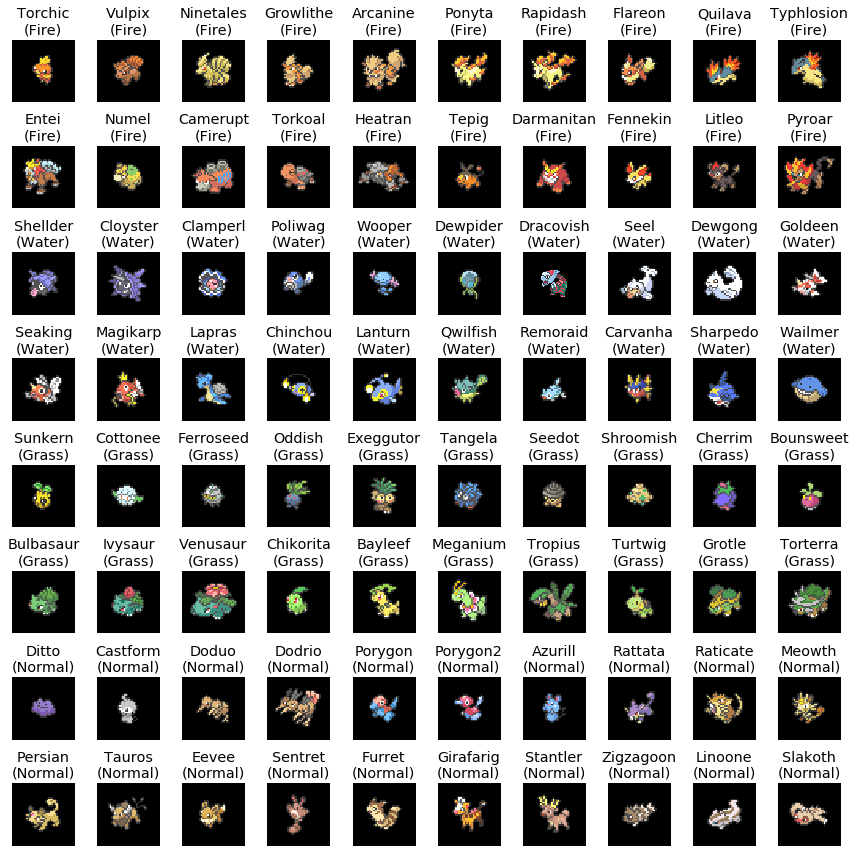

In [74]:
f,ax = plt.subplots(8,10,figsize = (12,12) )

split_axis = np.split(ax.flatten(),4)

for pokemon_type,subaxis in zip(['Fire','Water','Grass','Normal'],split_axis):
    
    for pokemon,ax_ in zip(filter(lambda x : x.element == pokemon_type, list_of_pokemon),
                           subaxis):

        ax_.margins(x=0)
        ax_.imshow(pokemon.array)

        ax_.set_title(f"{pokemon.name}\n({pokemon.element})" )
        ax_.axis('off')

plt.subplots_adjust(wspace = 0.0)
plt.tight_layout()

<h2> Workflow for optimization </h2>

<p> If our classification system is working, it should be able to predict the types of Pokemon it hasn't seen before. We also use the verb *generalize* to indicate that a system has learned a set of rules to map between inputs and outputs that remain valid on data it hasn't seen before. 
    
So how to we know how the classifier will perform on data it hasn't seen? To do this, we first split the data into a training set (which we feed to the ML classifier), and a test set (which we forbid the classifier from look at until we want to evaluate performance). So the Machinear Learning workflow is the following:   
0. Preprocess the input data (features): this may include rescaling, shifting, or changing the structure of matrices.
1. Split the dataset of Pokemon into a training dataset (67% of data), and a test dataset (33 % of data). We then hide the test dataset away. We don't have to choose that ratio of test to train data, but it's a good start.
1. Propose some model, $\mathcal{M}$, which is a set of maps between the image data and the categorical output ('Fire', 'Water' etc.) I'm saying a *set* of maps, because the precise map it is (i.e. which images correspond to which categorical type), is governed by a set of model parameters, $\vec{\theta}$. For a simple comparison: if the problem were linear regression, then the model would be the set of all possible straight lines. One particular straight line is specified by the value of the intercept and gradient; this is what I mean by the set of model parameters. 
1. Define a loss function, $L(\vec{\theta},y_{pred}(\vec{\theta}),y)$. This takes the parameters, $\vec{\theta}$, the predicted output, $y_{pred}$, and the true (ground truth) output data, $y$. The loss function is a scalar which corresponds to how much the model sucks. You have to choose this, along with the model, and you have to use your intuition about what consitutes a good loss function. For linear regression, you might choose to minimise the sum of squared error. For a binary classification problem, you might want to minimize the number of misclassified examples.
1. Do numerical optimization to minimize $L(\vec{\theta},y_{pred},y)$, by varying $\theta$. The notation for this is $\vec{\theta}^{(opt.)} = \textrm{argmin}_{\vec{\theta}} \big[L(\vec{\theta},y_{pred}(\vec{\theta}),y)\big]$. We only use the test dataset to do this minimization!
1. Evaluate $L(\vec{\theta},y_{pred},y)$, where $y$ is the in sample error. Now, we see if the model has learned something! If the model has learned something, then when we apply the model which has been trained on the training dataset to the unseen test dataset, then we'll get a decent value of the loss function. If it does, the model is said to generalize. 
    
So basically what we're doing is:
1. Test train split
1. Propose a model (like linear regression, or logistic regression, or a neural network, or whatever) that has some parameters
1. Choose a loss function (like least squares, or cross entropy or whatever) that reflects your intuition about what good predictions are.
1. Change the parameters of the model until the loss function is minimized while optimizing only on the training dataset
1. See if the model which has been trained on the training dataset performs okay on the test dataset.
</p>

In [75]:
type_to_int = {'Normal':0,
               'Fire':1,
               'Grass':2,
               'Water':3}
int_to_type = {type_to_int[val] : val for val in type_to_int}

In [76]:
from sklearn.model_selection import train_test_split

def preprocess_data(X,y):

    X_flat = list([x.flatten()/255. for x in X]) #N.B: I'm flattening all of the data...
    y_2 = list(map(lambda x : {'Normal':0,
                                    'Fire':1,
                                    'Grass':2,
                                    'Water':3}[x],y), #I'm also mapping Normal->0, Fire->1 etc
                   )
    
    return X_flat,y_2

X_flat,y_2 = preprocess_data(X,y)
    
X_train, X_test, y_train, y_test = train_test_split(X_flat,y_2, 
                                                  test_size = 0.33,
                                                  random_state=1,
                                                  stratify = y_2)


<h4> 1. Test train split </h4>

In [77]:
X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])

<p> Just a note: when I split the data into training and test datasets, I make sure to do so evenly across all classes -- this is called a stratified split. The basic problem is that I might only have like 20 grass pokemon. So if I split the training dataset randomly, there's a possibility that all grass pokemon end up in the test dataset (unlikely but possible). This would suck, because obviously my model isn't going to know what a grass Pokemon looks like if it's never seen a grass Pokemon before. The stratified split splits evenly across all classes (so the training dataset has representative fractions of the different Pokemon types), and therefore avoids this.</p> 

In [78]:
#so now we have a training dataset
print (f"we have {len(X_train)} training samples")
print (f"we have {len(X_test)} test samples")

we have 235 training samples
we have 117 test samples


<h3> Applying a first model</h3>

<p> My workflow for doing practical machine learning problems is to start with a super super simple model, and work out the error (for whatever loss function we choose). Then design a slightly more complex model, and then evaluate the error and see if it's better. This is good from a psychological perspective, because you feel like you're always making progress. </p>

<p> Building gradually more complicated models is also good because in a real problem I will have almost definitely made a mistake somewhere in setting the problem up -- choosing loss function / downloading the data / processing the data. This is more obvious if you use a very simple model first -- complex neural networks can fail for lots of reasons, but a linear regression will only fail if you suck, or if the underlying relationship between input and output is complex or non-monotonic. </p>

<h4> 2. Choosing a model </h4>

<h3> Logistic Regression </h3> 

<b> You don't actually need any theoretical understanding for the classifiers from Sklearn to work. The default settings are pretty great almost all the time. But I feel I should at least describe some of the theory about what's going on. </b>

<p> Logistic regression is a simple classifier. If we just had a binary problem (i.e. the outputs were class 0 and 1), the output would be the probability of being class 1 is: 
    
\begin{align}
    p(\text{class 1}) = \frac{1}{1+e^{-(\theta_0 + \theta_1x_1 + \theta_2x_2 + ...)}}.
\end{align}
    
This is a function called a logit, which ranges between 0 and 1. $\theta_0$, $\theta_1$ etc. are the elements of $\vec{\theta}$, the model parameters.

Here, the $x_i$ are features. In this problem $x_i$ correspond to pixel values at specific locations. Our image is 40x40x3 (last is rgb), so there are 4800 different input parameters, $x_1$,$x_2$,...,$x_{4800}$. This means there are 4801 different model parameters. 
    
But there is more than one type of Pokemon! There are lots of types. So we generalize this logistic regression model in the following way...
    
We arbitrarily select one of the types (say Normal) to be the "pivot". Then if we have N classes, we do N-1 logistic regressions, between each of the ones which aren't the pivot, and the pivot. So we do separate pairwise logistic regressions between Fire and Normal, and between Water and Normal, and between Grass and Normal. Then we combine these separate models. More details are given here: 
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
    
</p>

<p> Also, what loss function are we going to use? We *could* use the fraction of misclassified examples. But our model outputs a probability distribution over all the classes for each value of X. So it makes sense to use a loss function which encodes this, punishing the model for being confidently wrong, while rewarding it for being confidently right.</p>

<p> The particular quantity we choose to optimize is called the log-loss, which we optimize for each individual pair. For each pairwise optimization (say between Fire, and Normal), the log loss is given by:
    
The log loss function is given by:
    
\begin{align}
-\frac{1}{N}\sum_{i=1}^N y_i \log(p(y_i)) + (1-y_i)\cdot \log(1-p(y_i))
\end{align}

   
Here, there are $N$ samples, and the true value of the ith sample is $y_i$. In this particular regression, the true values of $y$ are either 0 (i.e. is Normal), or 1 (i.e. is Fire). Our classifier outputs a probability that (given the input), the output is Fire, and this is given by $p(y_i)$. 
    
This function looks a bit arcane, but it's got some interesting properties. Log loss is minimized (at $0$), if we're fully confident in our predictions, and they're all right. But if we are ever fully confident (with probability 1 or 0), and we're wrong, our log loss diverges. So the function teaches the classifier to be conservative in predictions.
    
Elementwize log loss functions are graphed below, demonstrating that if the model is fully confident and correct, log loss is 0, and if fully confident and incorrect, log loss is $\infty$.
    
(Incidentally, the true loss function sklearn uses includes a term for regularization to prevent overfitting, <a> https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a</a>)
    
    
More precise details on the log-loss function are given on: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a and here: 
http://neuralnetworksanddeeplearning.com/chap3.html
</p>

/home/wtk23/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0.5, 0, 'prediction prob')

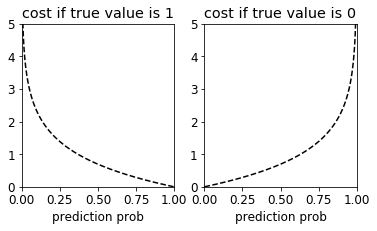

In [82]:
f,ax = plt.subplots(1,2,figsize = (6,3))
x = np.linspace(1/1000,1,1000)
ax[0].plot(x,-np.log(x),'k--')
ax[1].plot(x,-np.log(1-x),'k--')
for a in ax: a.set_xlim(0,1) ; a.set_ylim(0,5)
ax[0].set_title('cost if true value is 1')
ax[1].set_title('cost if true value is 0')

ax[0].set_xlabel('prediction prob')
ax[1].set_xlabel('prediction prob')

<h4> 4. Training parameters on the training dataset </h4>

<p> Scikit-learn is a Python package with many classifiers / regressors / general infrastructure for machine learning. To use a model, import it, create an instantiation, and then apply the method fit, as shown below. </p>

In [91]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = 1, max_iter = int(1e7))

lr.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<h4> 5. Evaluate performance on the test dataset </h4>

<p> Scikit learn models also have the method "predict", where a trained model predicts the output corresponding to its arguments </p> 

In [92]:
#in sample error
y_train_pred = lr.predict_proba(X_train)

from sklearn.metrics import log_loss

log_loss(y_train,y_train_pred)

y_pred = lr.predict_proba(X_test)

print (f"(in sample) logistic regression log loss is {log_loss(y_train,y_train_pred)}")
print (f"(out of sample) logistic regression log loss is {log_loss(y_test,y_pred)}")

(in sample) logistic regression log loss is 0.052490955956469895
(out of sample) logistic regression log loss is 1.3276543278721191


<p> This system performs very well on data it's seen before (in sample) -- it's log loss is close to 0, at 0.05. But it performs much less well on data it hasn't seen before (out of sample). i.e. The model is learning to memorize specific input-output pairs, rather than learning to infer deep rules about what consitutes a fire type / water type etc. This is a typical failure mode you would expect if your model has thousands of parameters, like this one. This is referred to as a failure to generalize.</p>

A visual way to look at the failures of our classification system is to use a confusion matrix. If we have N different samples, the confusion matrix row $i$, column $j$ is the number of samples whose true class is $i$, and whose predicted class is $j$. So the number of Normal type which were correctly predicted is in entry (0,0) in the matrix; the number of true Normal type which are misclassified as Fire type is in entry (0,1). 

Text(0, 0.5, 'Ground truth')

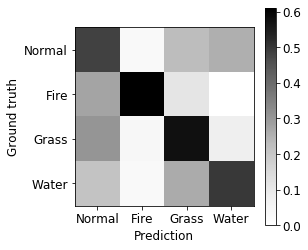

In [93]:
from sklearn.metrics import confusion_matrix
y_pred_absolute = lr.predict(X_test)
cf = confusion_matrix(y_test, y_pred_absolute)

cf_normed = []
for i in cf:
    cf_normed.append(i/np.sum(i))

f,ax = plt.subplots(1,1,figsize = (4,4))
plt.imshow(cf_normed,cmap = "Greys") #normalize...
plt.colorbar()

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Normal','Fire','Grass','Water'])

ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['Normal','Fire','Grass','Water'])

ax.set_xlabel('Prediction')
ax.set_ylabel('Ground truth')

<p> This lets us see exactly what how our classifier is failing! We can see that of types which are true Normal, we're misclassifying about 20% as grass, and water, but we're never misclassifying normal types as fire types. </p>

<h3> Can we do better?</h3>

<h4> Feature Engineering </h4>

<p> We know that pretty obviously pokemon types are based on color palette. So maybe, one way to make our classifier much better is to design a feature that fits our intuition about how type is predicted. </p>

<p> One obvious feature is the average pixel color across all pixels which are not blank. This consists of 3 floats, its 'redness', its 'blueness' and its 'greeness' </p>

In [94]:
def make_average_pixel_feature(x):
    x_reshaped = x.reshape(1600,-3)
    loc_0 = np.where(np.sum(x_reshaped,axis = 1) != 0)
    mean_pixels = np.mean(x_reshaped[loc_0],axis = 0)
    return mean_pixels 

In [95]:
X_train_single_pixel = np.array([make_average_pixel_feature(x) for x in X_train])

X_test_single_pixel = np.array([make_average_pixel_feature(x) for x in X_test])

<p> Now we've manually reduced the dimensionality to 3D, we can see if there are obvious clusters, (as we might expect) </p>

<p> Below, I have plotted the single average pixel for each of element in the training dataset. Color codes are red for fire, green for grass, blue for water, and black for normal </p>

In [96]:
colors = list(map(lambda i : {0:[0,0,0], 1:[1,0,0],2:[0,1,0],3:[0,0,1]}[i],  y_train))

Text(0, 0.5, 'blue')

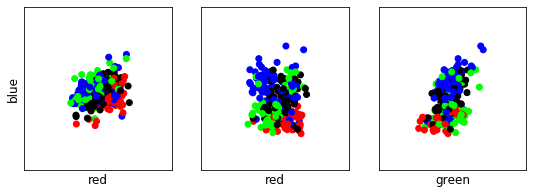

In [97]:
f,ax = plt.subplots(1,3,figsize = (9,3))
ax[0].scatter(X_train_single_pixel[:,0],X_train_single_pixel[:,1],c = colors,)
ax[1].scatter(X_train_single_pixel[:,0],X_train_single_pixel[:,2],c = colors,)
ax[2].scatter(X_train_single_pixel[:,1],X_train_single_pixel[:,2],c = colors,)

for a in ax:
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    a.set_xticks([])
    a.set_yticks([])
    
ax[0].set_xlabel('red') ; ax[0].set_ylabel('green')
ax[1].set_xlabel('red') ; ax[0].set_ylabel('blue')
ax[2].set_xlabel('green') ; ax[0].set_ylabel('blue')


<p> It seems that our average pixel approach doesn't obviously delineate the classes; it would be difficult to draw a boundary between Fire and Water etc. We can still try applying a logistic regression.</p>

In [98]:
lr_engineered = LogisticRegression()

lr_engineered.fit(X_train_single_pixel,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
y_train_pred = lr_engineered.predict_proba(X_train_single_pixel)

in_sample_log_loss = log_loss(y_train,y_train_pred)

y_pred = lr_engineered.predict_proba(X_test_single_pixel)
y_pred_absolute = lr_engineered.predict(X_test_single_pixel)


print (f"(in sample) logistic regression log loss is {in_sample_log_loss}")
print (f"(out of sample) logistic regression log loss is {log_loss(y_test,y_pred)}")

(in sample) logistic regression log loss is 1.1531801656403977
(out of sample) logistic regression log loss is 1.1783613365144945


<p> Interesting! Our logistic regression over the average pixel has performed better than our logistic regression over all pixels! (recall that our log loss for the logistic regression over all pixels was 1.40). Also, it has generalized much much better (i.e. our in sample error is comparable to our out of sample error, so our model has actually learned underlying features of the data, rather than just memorized examples! Typically, high dimensional systems (we have 4800 dimensions here) with few training examples see peak performance NOT when a highly complex model is developed, but instead when a domain specific expert designs features accoring to intuition, and domain specific understanding.</p>

<h4> Ways you can extend this </h4>

<p> Here, we've only touched the basics of ML prediction systems. If you want to improve the performance of our model further, there are lots of things you can play with:

1. One could add additional hand designed features to the single pixel classification system. Maybe add the sum of RGB pixels to the logistic regression as a feature?
1. Use a systematic dimensionality reduction tool, like PCA to reduce the number of free parameters in the image <a> https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html</a>
1. For the logistic regression over all pixel values, you could artificiallly expand the dataset, by including rotations and reflections <a> https://www.kdnuggets.com/2020/02/easy-image-dataset-augmentation-tensorflow.html </a>
1. You can add other types ("Dark", "Electric"), and see how well your model performs.
1. Identify problematic examples, whose ground truth is one type, but which the classifier confidently predicts are another.
</p>